<a href="https://colab.research.google.com/github/yangmz0528/Cracks_Dectection/blob/main/Crack_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concrete Crack Image Detection



## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

import os, json
import cv2
from glob import glob
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, layers, callbacks
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input, Conv2D, MaxPool2D, BatchNormalization


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Download Dataset and making into a DataFrame

In [3]:
!ls

drive  sample_data


In [4]:
!wget -qq https://www.dropbox.com/s/bpy28t6mgbu96wq/crack_classification.zip
!unzip -qq crack_classification.zip
!rm crack_classification.zip

!ls

archive  drive	sample_data


In [5]:
!ls archive

Negative  Positive


In [6]:
# use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.
negative_dir = glob.glob('./archive/Negative/*.jpg')
positive_dir = glob.glob('./archive/Positive/*.jpg')


names = ['negative', 'positive']

# Check
len(negative_dir)

20000

In [7]:
# Create a function to see some images 

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        if len(images)>3:
            break
    fig=plt.figure(figsize=(10,12))
    xrange=range(1,5)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

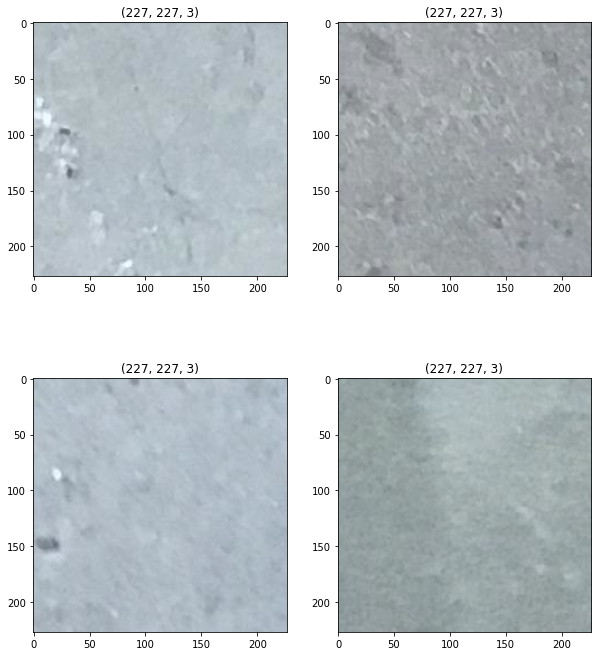

In [8]:
load_images_from_folder("./archive/Negative/")

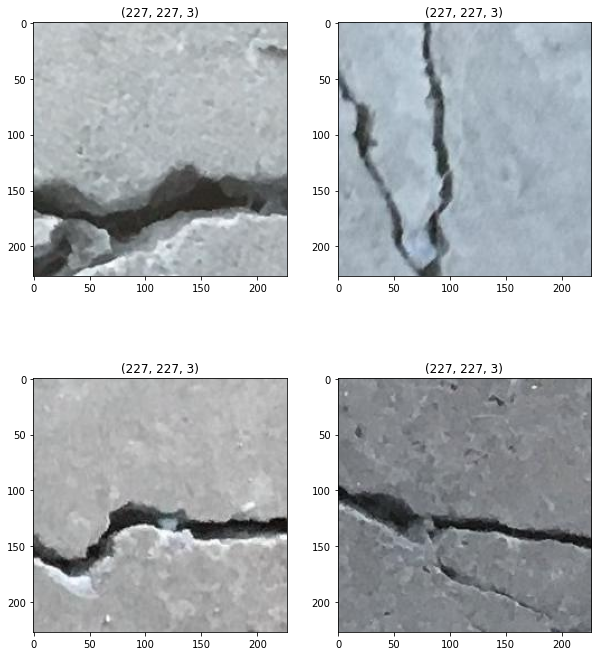

In [9]:
load_images_from_folder("./archive/Positive/")

In [10]:
# Make a dataframe based on the filenames
df_neg = pd.DataFrame(negative_dir, columns = ["filename"])
df_pos = pd.DataFrame(positive_dir, columns = ["filename"])


# Add Class columns 
df_neg['class'] = pd.Series([0 for x in range(len(df_neg.index))], index=df_neg.index)
df_pos['class'] = pd.Series([1 for x in range(len(df_pos.index))], index=df_pos.index)

# Concat both dataframes (negative & positive) & Shuffle
df_final = pd.concat([df_neg, df_pos], axis=0).sample(frac=1.0).reset_index(drop=np.true_divide)
df_final['class'] = df_final['class'].astype(str)


In [11]:
df_final.head()

,filename,class
0,./archive/Negative/01093.jpg,0
1,./archive/Positive/00878.jpg,1
2,./archive/Positive/08382.jpg,1
3,./archive/Positive/05660.jpg,1
4,./archive/Negative/01784.jpg,0


0    20000
1    20000
Name: class, dtype: int64


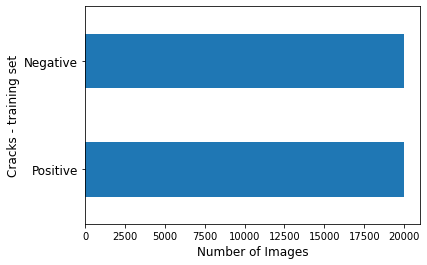

In [12]:
# Examine the data
print(df_final['class'].value_counts())


ax = df_final['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Images", fontsize=12)
ax.set_ylabel("Cracks - training set", fontsize=12)
ax.set_yticklabels(['Positive','Negative'], rotation=0, fontsize=12)
plt.show()

In [13]:
 # Train-test split the data
 train_df, test_df = train_test_split(
     df_final.sample(40000, random_state=42),
     train_size=0.8,
     shuffle=True,
     random_state=42
 )

## 3. Loading Image Data

In [14]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255 # do not include validation split
)

In [15]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(128, 128), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False, # do not shuffle the test
    seed=42
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


## 4. Training the Model - CNN

In [16]:
inputs = Input(shape=(128, 128, 3))
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

#Dense
x = GlobalAveragePooling2D()(x) # or do flattening
outputs = Dense(1, activation='sigmoid')(x)

model_cnn = Model(inputs=inputs, outputs=outputs)

print(model_cnn.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248  

In [17]:
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [18]:
history_cnn = model_cnn.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/checkpoints/CNN_ep{epoch:02d}_val{val_loss:.2f}.hdf5", verbose=1, save_best_only=True, mode='auto'),
        callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/checkpoints/CNN_model_history.csv')
    ]
)

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9385
Epoch 1: val_loss improved from inf to 0.06782, saving model to drive/MyDrive/Colab Notebooks/checkpoints/CNN_ep01_val0.07.hdf5
800/800 [==============================] - 52s 61ms/step - loss: 0.1660 - accuracy: 0.9385 - val_loss: 0.0678 - val_accuracy: 0.9823
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9761
Epoch 2: val_loss did not improve from 0.06782
800/800 [==============================] - 44s 56ms/step - loss: 0.0835 - accuracy: 0.9761 - val_loss: 0.0698 - val_accuracy: 0.9777
Epoch 3/100
799/800 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9801
Epoch 3: val_loss improved from 0.06782 to 0.05523, saving model to drive/MyDrive/Colab Notebooks/checkpoints/CNN_ep03_val0.06.hdf5
800/800 [==============================] - 44s 55ms/step - loss: 0.0695 - accuracy: 0.9800 - val_loss: 0.0552 - val_accuracy: 0.9852
Epo

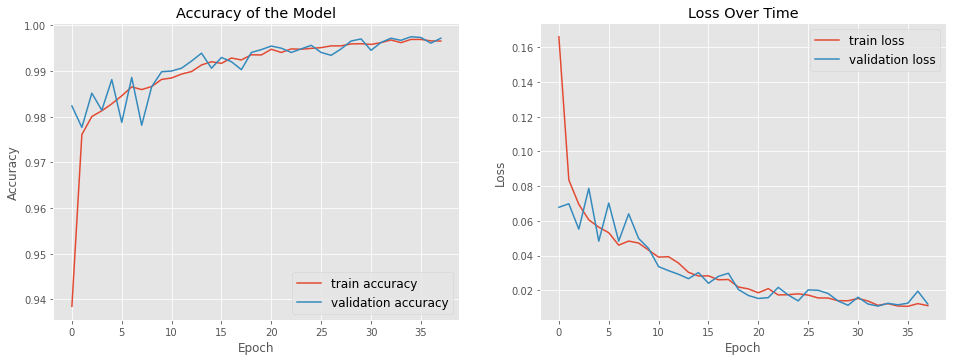

In [19]:
plt.figure(figsize=(16, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Loss Over Time')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})


In [20]:
# Evaluation of Model

def evaluate_model(model, test_data, prefix=''):
  results = model.evaluate(test_data, verbose=0)
  loss = results[0]
  acc = results[1]
  print("Test Loss: {:.5f}".format(loss))
  print("Test Accuracy: {:.2f}".format(acc*100))

  y_pred = np.squeeze(model.predict(test_data)>=0.5).astype(int)
  cm = confusion_matrix(test_data.labels, y_pred)
  clr = classification_report(test_data.labels, y_pred, target_names=['Negative', 'Positive'])

  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=np.arange(2) + 0.5, labels=['Negative', 'Positive']) # get ticks in the middle of the boxes
  plt.yticks(ticks=np.arange(2) + 0.5, labels=['Negative', 'Positive'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix - "+prefix)
  plt.show()

  print("Classification Report: \n ----------------------\n", clr)

Test Loss: 0.01845
Test Accuracy: 99.64
250/250 [==============================] - 11s 43ms/step


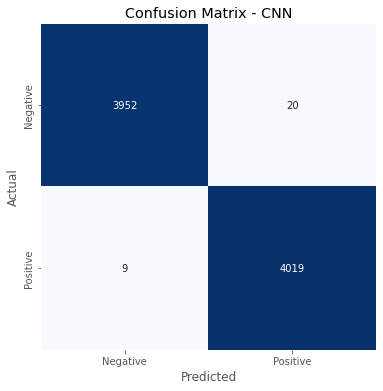

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      0.99      1.00      3972
    Positive       1.00      1.00      1.00      4028

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [21]:
evaluate_model(model_cnn, test_data, prefix='CNN')

## 5 - Tranfer Learning - VGG16

In [24]:
train_gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    validation_split = 0.2
)

test_gen_mobile = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)

In [25]:
train_data_vgg = train_gen_mobile.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), # vgg16 default
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data_vgg = train_gen_mobile.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data_vgg = train_gen_mobile.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [26]:
# Download feature extractor

feature_extractor = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False, # build our own classification
    pooling='avg'
)

feature_extractor.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [30]:
last_layer = feature_extractor.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_vgg = Model(inputs=inputs, outputs=outputs)

print(model_vgg.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
model_vgg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [34]:
# Train the model

history_vgg = model_vgg.fit(
    train_data_vgg,
    validation_data = val_data_vgg,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/checkpoints/VGG16_ep{epoch:02d}_val{val_loss:.2f}.hdf5", verbose=1, save_best_only=True, mode='auto'),
        callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/checkpoints/VGG16_model_history.csv')
        
    ]
)

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9930
Epoch 1: val_loss improved from inf to 0.00431, saving model to drive/MyDrive/Colab Notebooks/checkpoints/VGG16_ep01_val0.00.hdf5
800/800 [==============================] - 170s 208ms/step - loss: 0.0187 - accuracy: 0.9930 - val_loss: 0.0043 - val_accuracy: 0.9984
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9977
Epoch 2: val_loss did not improve from 0.00431
800/800 [==============================] - 163s 204ms/step - loss: 0.0101 - accuracy: 0.9977 - val_loss: 0.0075 - val_accuracy: 0.9973
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9984
Epoch 3: val_loss improved from 0.00431 to 0.00197, saving model to drive/MyDrive/Colab Notebooks/checkpoints/VGG16_ep03_val0.00.hdf5
800/800 [==============================] - 163s 204ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0020 - val_accuracy: 

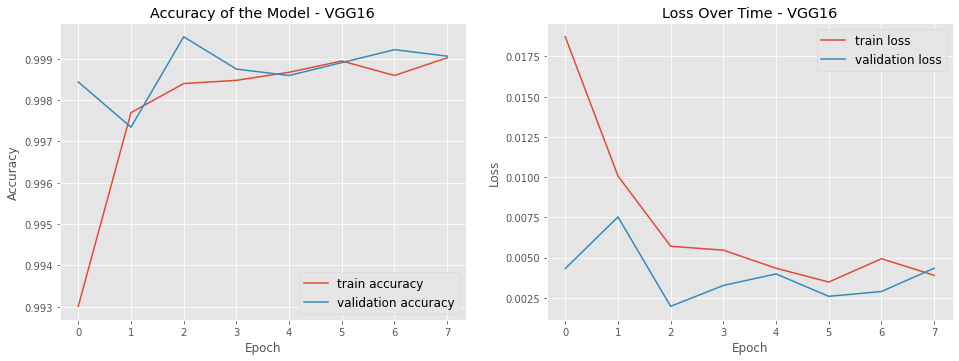

In [35]:
plt.figure(figsize=(16, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('Accuracy of the Model - VGG16')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title('Loss Over Time - VGG16')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

Test Loss: 0.00749
Test Accuracy: 99.87
250/250 [==============================] - 39s 158ms/step


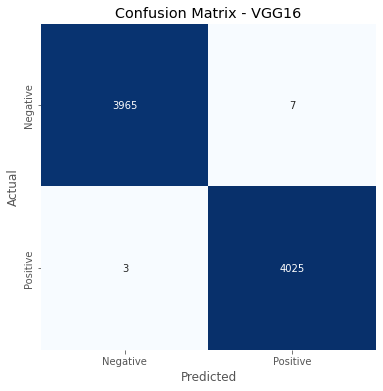

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3972
    Positive       1.00      1.00      1.00      4028

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [36]:
evaluate_model(model_vgg, test_data_vgg, prefix='VGG16')

## 6 - Tranfer Learning - InceptionV3

In [37]:
train_gen_incep = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input,
    validation_split = 0.2
)

test_gen_incep = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
)

In [38]:
train_data_incep = train_gen_incep.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299), # inceptionv3 default
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data_incep = train_gen_incep.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data_incep = train_gen_incep.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(299, 299), 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42,
)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


In [39]:
# Download feature extractor

feature_extractor_incep = tf.keras.applications.InceptionV3(
    input_shape=(299, 299, 3),
    weights='imagenet',
    include_top=False, # build our own classification
    pooling='avg'
)

feature_extractor_incep.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [40]:
feature_extractor_incep.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d_4')>

In [41]:
# We will use the part of the pre_trained model from input later until the layer 'mixed10'
# You can also choose different layer for starting
last_layer = feature_extractor_incep.get_layer('mixed10') 
last_output = last_layer.output

#takes a average pooling in a way that flattenning an amount
x = GlobalAveragePooling2D()(last_output)
x = Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)  
outputs = Dense(1, activation='sigmoid')(x)   

model_incep = Model(inputs=feature_extractor_incep.inputs, outputs=outputs)

print(model_incep.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d_3[0][0]']               
 alization)                     )                                                           

In [42]:
model_incep.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [43]:
# Train the model

history_incep = model_incep.fit(
    train_data_incep,
    validation_data = val_data_incep,
    epochs=100,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        callbacks.ModelCheckpoint("drive/MyDrive/Colab Notebooks/checkpoints/incepV3_ep{epoch:02d}_val{val_loss:.2f}.hdf5", verbose=1, save_best_only=True, mode='auto'),
        callbacks.CSVLogger('drive/MyDrive/Colab Notebooks/checkpoints/incepV3_model_history.csv')
    ]
)

Epoch 1/100
800/800 [==============================] - ETA: 0s - loss: 0.0199 - accuracy: 0.9946
Epoch 1: val_loss improved from inf to 0.00813, saving model to drive/MyDrive/Colab Notebooks/checkpoints/incepV3_ep01_val0.01.hdf5
800/800 [==============================] - 143s 170ms/step - loss: 0.0199 - accuracy: 0.9946 - val_loss: 0.0081 - val_accuracy: 0.9980
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9972
Epoch 2: val_loss improved from 0.00813 to 0.00591, saving model to drive/MyDrive/Colab Notebooks/checkpoints/incepV3_ep02_val0.01.hdf5
800/800 [==============================] - 131s 163ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0059 - val_accuracy: 0.9983
Epoch 3/100
800/800 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9985
Epoch 3: val_loss did not improve from 0.00591
800/800 [==============================] - 128s 159ms/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.0130 - val_accura

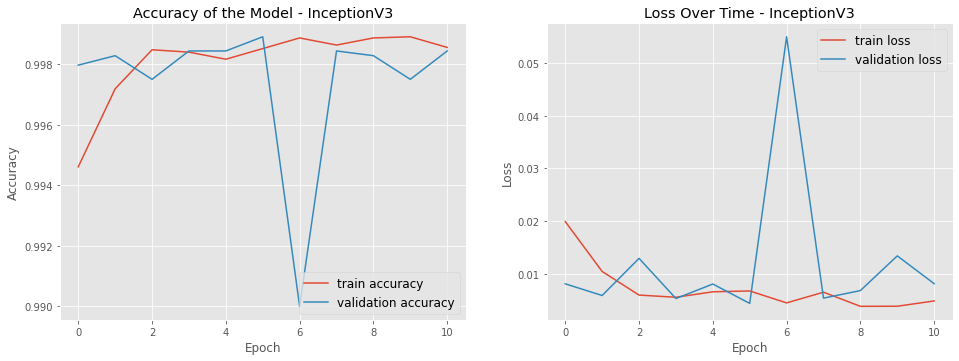

In [44]:
plt.figure(figsize=(16, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history_incep.history['accuracy'])
plt.plot(history_incep.history['val_accuracy'])
plt.title('Accuracy of the Model - InceptionV3')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train accuracy', 'validation accuracy'], loc='lower right', prop={'size': 12})

plt.subplot(2,2,2)
plt.plot(history_incep.history['loss'])
plt.plot(history_incep.history['val_loss'])
plt.title('Loss Over Time - InceptionV3')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train loss', 'validation loss'], loc='best', prop={'size': 12})

Test Loss: 0.01191
Test Accuracy: 99.79
250/250 [==============================] - 32s 123ms/step


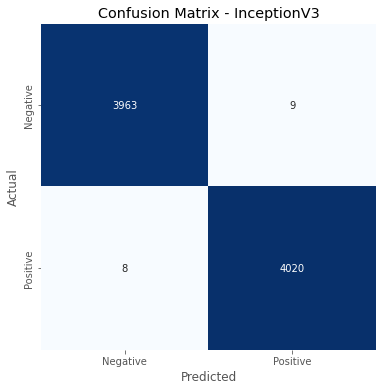

Classification Report: 
 ----------------------
               precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      3972
    Positive       1.00      1.00      1.00      4028

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [45]:
evaluate_model(model_incep, test_data_incep, prefix='InceptionV3')

In [ ]:
# kill the VM and restart Colab with a new machine
!kill -9 -1